# The Important knobs and their interplay in the Optimisers

**Note:** I'll be very happy to accept suggestions to make this more lucid for the readers to understand. Anyone seeing this, having a suggestion in mind, please leave a message at my

linkedin profile: www.linkedin.com/in/pratik-karmakar-271a89148 
or
email : pkpratikkarmakar@gmail.com

# How Batch Size and Momentum work in minimizing a loss function:

While running our machine learning and deep learning algorithms, we have noticed that working with the whole dataset becomes somewhat vigorously memory inefficient process. Thus we move to stochastic gradient descent methods and that too has its own disadvantages like more randomness than needed. To compensate this we take minibatches of data which is something between batch gradient and stochastic gradient (this solves the memory problem and also the randomness problem).

We simulate SGD with Perturbed Gradient Descent method and minibatch GD with Averaged Perturbed Gradient Descent.

We have interactive plots below. You can see how tweaking the parameters can make the algorithm work faster and in a more reliable way. Hope you enjoy this experience.

In [1]:
import numpy as np
import pandas as pd
import jax.numpy as jnp
from jax import jacfwd, jacrev, grad
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np

%matplotlib nbagg

In [2]:
def f1(x):
    return x[0]**2+2*x[1]**2

def f2(x):
    return x[0]**2-2*x[1]**2

def f3(x):
    return 0.1*x[0]**2+2*x[1]**2

In [3]:
def SGD(f,x,it=1000,lr=0.1,lr_method="piecewise",mom=0.5,e=10e-3,prd=2,lmbda=0.1,alpha=0.5,beta=1,bsz=1,noise=0):
    """
Arguments description:

f is the function to be minimized

x is the starting point

it is the number of iterations

lr_method takes 3 possible inputs: 
"Piecewise Linear"(default), "Exponential Decay", "Polynomial Decay"

e is the tolerance level

prd is reduction rate in piecewise case

lmbda is the exponent coeff for exponential decay

alpha is the exponent in polynomial decay

beta is the coeff in polynomial decay

mom is the momentum added to the algorithm

noise is amount of noise added to the algorithm (simulation of SGD(bsz=1) and minibatch(bsz>1)).
"""
    
    x=np.array(x,dtype="float32")
    g=jacrev(f)
    y=x-lr*(np.array(g(x))+noise*sum(np.random.randn(bsz,len(x)))/bsz)
    X=[x,y]
    LR=[lr]
    func_val=[f(x),f(y)]
    steps=[]
    conv_rate=[0,0]
    grads=[g(x),g(y)]
    k=0
    
    # Code for piecewise learning rate
    if lr_method=="Piecewise Linear":
        LR.append(lr)
        gradm=[g(y)+mom*g(x)]
        while np.abs(f(y)-f(x))>e and k<it:
            k+=1
            if f(y)<f(x):
                x=y              
                y=y-lr*(np.array(gradm[-1])+noise*sum(np.random.randn(bsz,len(x)))/bsz)
            else:
                lr=lr/prd
                x=y               
                y-=lr*(np.array(gradm[-1])+noise*sum(np.random.randn(bsz,len(x)))/bsz)
            LR.append(lr)
            X.append(y)
            gradm.append(g(y)+mom*gradm[-1])
            grads.append(g(y))
            func_val.append(f(y))
            steps.append(k+2)
        for i in range(len(X)-2):
            conv_rate.append(np.linalg.norm((X[i+2])-(X[i+1]))/np.linalg.norm((X[i+1])-(X[i])))
    
    # Code for exponential decay of learning rate
    elif lr_method=="Exponential Decay":
        LR.append(lr)
        gradm=[g(y)+mom*g(x)]
        while np.abs(f(y)-f(x))>e and k<it:
            k+=1
            lr1=lr*np.exp(-lmbda*k)
            x=y
            y=y-lr1*(np.array(gradm[-1])+noise*sum(np.random.randn(bsz,len(x)))/bsz)
            LR.append(lr1)
            X.append(y)
            grads.append(g(y))
            gradm.append(g(y)+mom*gradm[-1])
            func_val.append(f(y))
            steps.append(k)
        for i in range(len(X)-2):
            conv_rate.append(np.linalg.norm((X[i+2])-(X[i+1]))/np.linalg.norm((X[i+1])-(X[i])))
    
    # Code for polynomial decay of learning rate
    elif lr_method=="Polynomial Decay":
        LR.append(lr)
        gradm=[g(y)+mom*g(x)]
        while np.abs(f(y)-f(x))>e and k<it:
            k+=1
            lr1=lr*(1+beta*k)**(-alpha)
            x=y
            y=y-lr1*(np.array(gradm[-1])+noise*sum(np.random.randn(bsz,len(x)))/bsz)
            LR.append(lr1)
            grads.append(g(y))
            gradm.append(g(y)+mom*gradm[-1])
            X.append(y)
            func_val.append(f(y))
            steps.append(k)
        for i in range(len(X)-2):
            conv_rate.append(np.linalg.norm((X[i+2])-(X[i+1]))/np.linalg.norm((X[i+1])-(X[i])))
            
        
    return {"Steps":steps,"Points":X,"Learning_rate":LR,"func_value":func_val,"Convergence_rate":conv_rate,"grads":grads}

In [4]:
#Splits the points into number of input coordinates

def split(x):
    a=np.array(x)
    X=[]
    for i in range(a.shape[1]):
        xi=a[:,i]
        X.append(xi)
    return (X)

We'll be checking on three functions.


# 1. $f_1=x_1^2+2x_2^2$ 
This is a well behaved (well behaved eigen structure of the hessian) convex function

<IPython.core.display.Javascript object>


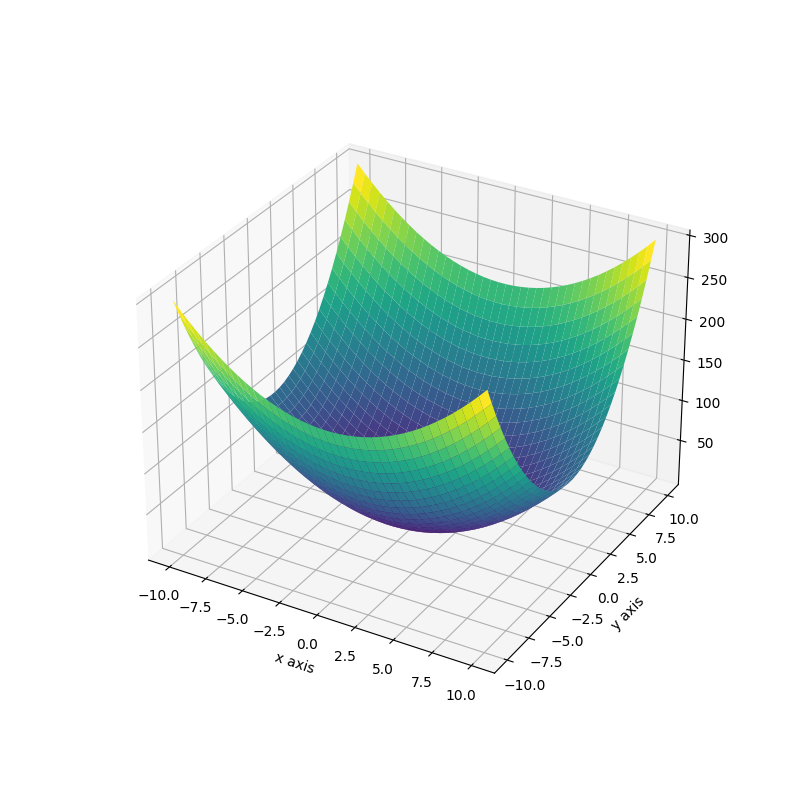

In [5]:
x=np.linspace(-10,10,40)
y=np.linspace(-10,10,40)
x,y=np.meshgrid(x,y)
z=f1((x,y))

fig = plt.figure(figsize =(8,8))
ax = plt.axes(projection ='3d')
plt.xlabel("x axis")
plt.ylabel("y axis")
ax.plot_surface(x, y, z,cmap="viridis")
plt.show()

# 2. $f_2=x_1^2-2x_2^2$
A function with a saddle point

<IPython.core.display.Javascript object>


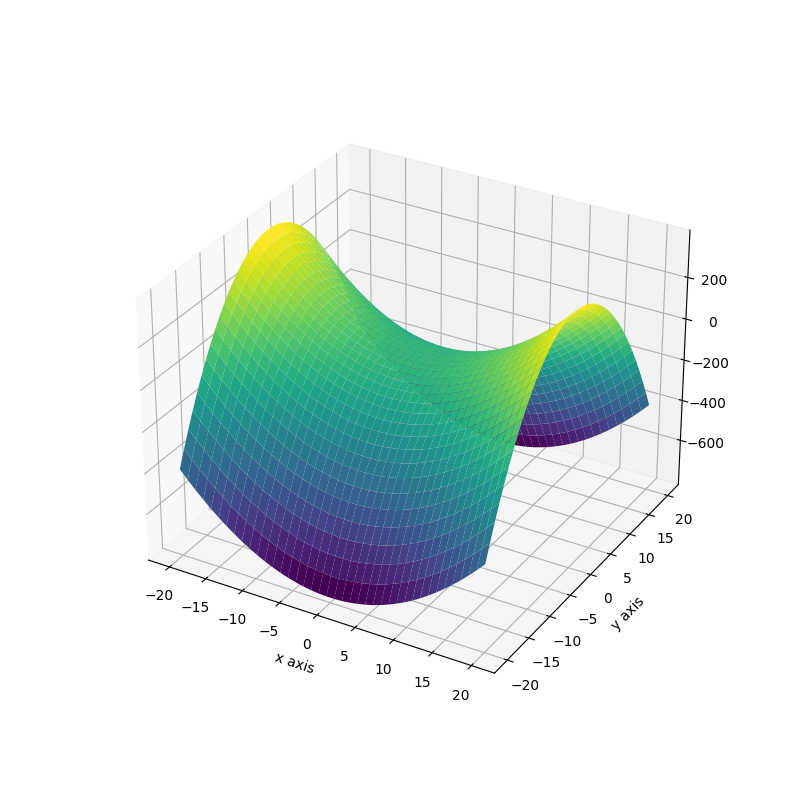

In [6]:
x=np.linspace(-20,20,40)
y=np.linspace(-20,20,40)
x,y=np.meshgrid(x,y)
z=f2((x,y))

fig = plt.figure(figsize =(8,8))
ax = plt.axes(projection ='3d')
plt.xlabel("x axis")
plt.ylabel("y axis")
ax.plot_surface(x, y, z,cmap="viridis")
plt.show()

# 3. $f_3=0.1x_1^2+2x_2^2$
A convex function with a not so well behaved eigen structure of its hessian

<IPython.core.display.Javascript object>


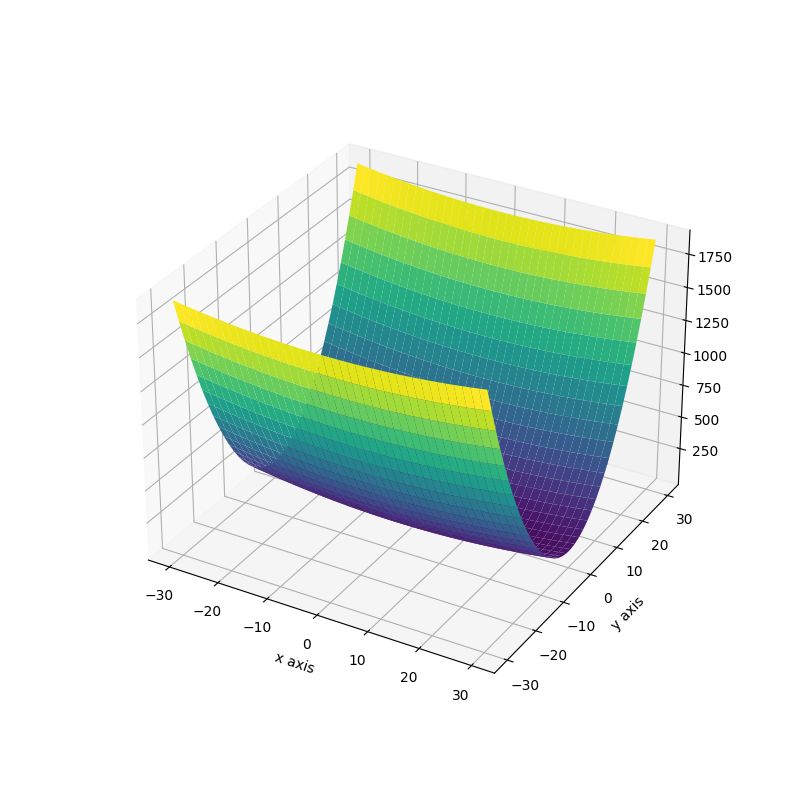

In [7]:
x=np.linspace(-30,30,40)
y=np.linspace(-30,30,40)
x,y=np.meshgrid(x,y)
z=f3((x,y))

fig = plt.figure(figsize =(8,8))
ax = plt.axes(projection ='3d')
plt.xlabel("x axis")
plt.ylabel("y axis")
ax.plot_surface(x, y, z,cmap="viridis")
plt.show()

<IPython.core.display.Javascript object>


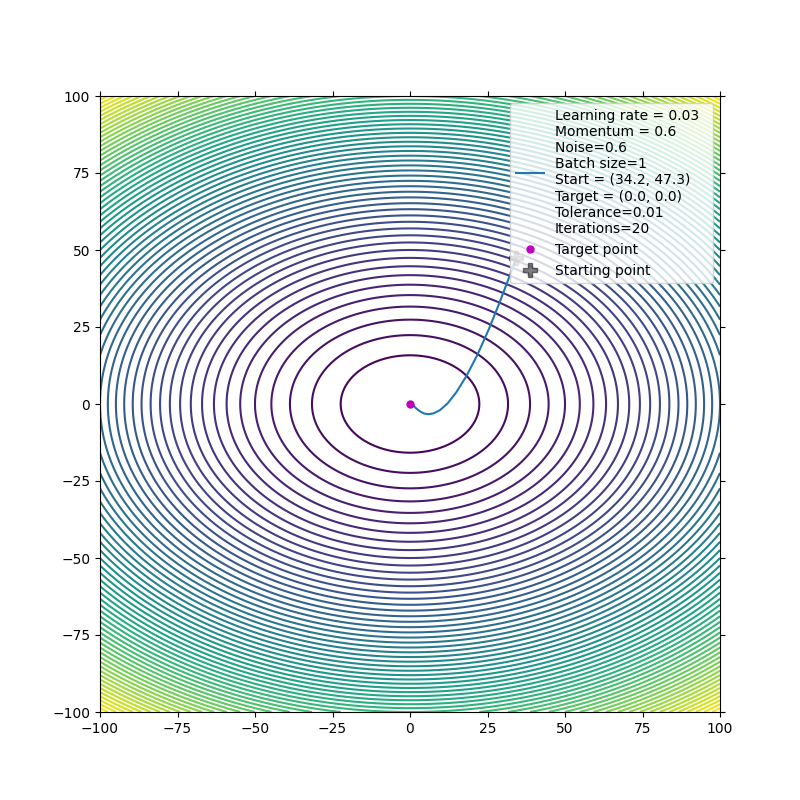

Widget Javascript not detected.  It may not be installed or enabled properly.


In [8]:
## 2D interactive plot

fig, ax = plt.subplots(1,figsize=(8,8))
ax.grid(True)  

def update_plot(lr,mom,startx,starty,targx,targy,noise,bsz,e,f,method):
    x=np.linspace(-100,100,400)
    y=np.linspace(-100,100,400)
    x,y=np.meshgrid(x,y)
    z=f((x,y))  
    ax.clear()
    x1,y1=split(SGD(f,(startx,starty),lr=lr,lr_method=method,mom=mom,e=e,bsz=bsz,noise=noise)["Points"])
    units = 'Learning rate = {}  \nMomentum = {} \nNoise={} \nBatch size={} \nStart = {} \nTarget = {} \nTolerance={} \nIterations={}'
    ax.contour(x,y,z,60)
    ax.plot(x1, y1, label=units.format(lr,mom,noise,bsz,(startx,starty),(targx,targy),e,len(x1)-1))
    ax.plot(targx,targy,"om",label="Target point",ms=5)
    ax.plot(startx,starty,"Pk",ms=10,alpha=0.5,label="Starting point")
    ax.legend(loc=1)
    plt.show()


lr = widgets.FloatSlider(min=0, max=1, value=0.03,step=0.01, description='Learning rate:')
mom = widgets.FloatSlider(min=0, max=1, value=0.6,step=0.01, description='Momentum:')
noise = widgets.FloatSlider(min=0, max=10, value=0.6,step=0.01, description='Noise:')
bsz=widgets.IntSlider(min=1, max=10000, value=0.6, description='Batch size:')
startx = widgets.FloatSlider(min=-100, max=100, value=4, description='Start point X:')
starty = widgets.FloatSlider(min=-100, max=100, value=3, description='Start point Y:')
targx = widgets.FloatSlider(min=-100, max=100, value=0, description='Target point X:')
targy = widgets.FloatSlider(min=-100, max=100, value=0, description='Target point Y:')
e=widgets.FloatSlider(min=0, max=1, value=10e-3,step=10e-6, description='Tolerance:')
f=widgets.Dropdown(options=[f1,f2,f3], description="Select the function")
method=widgets.Dropdown(options=["Piecewise Linear","Exponential Decay","Polynomial Decay"], description="Select the scheduler")   

widgets.interactive(update_plot, lr=lr, mom=mom,bsz=bsz, startx=startx,starty=starty,targx=targx,targy=targy,e=e,f=f,noise=noise,method=method)

<IPython.core.display.Javascript object>


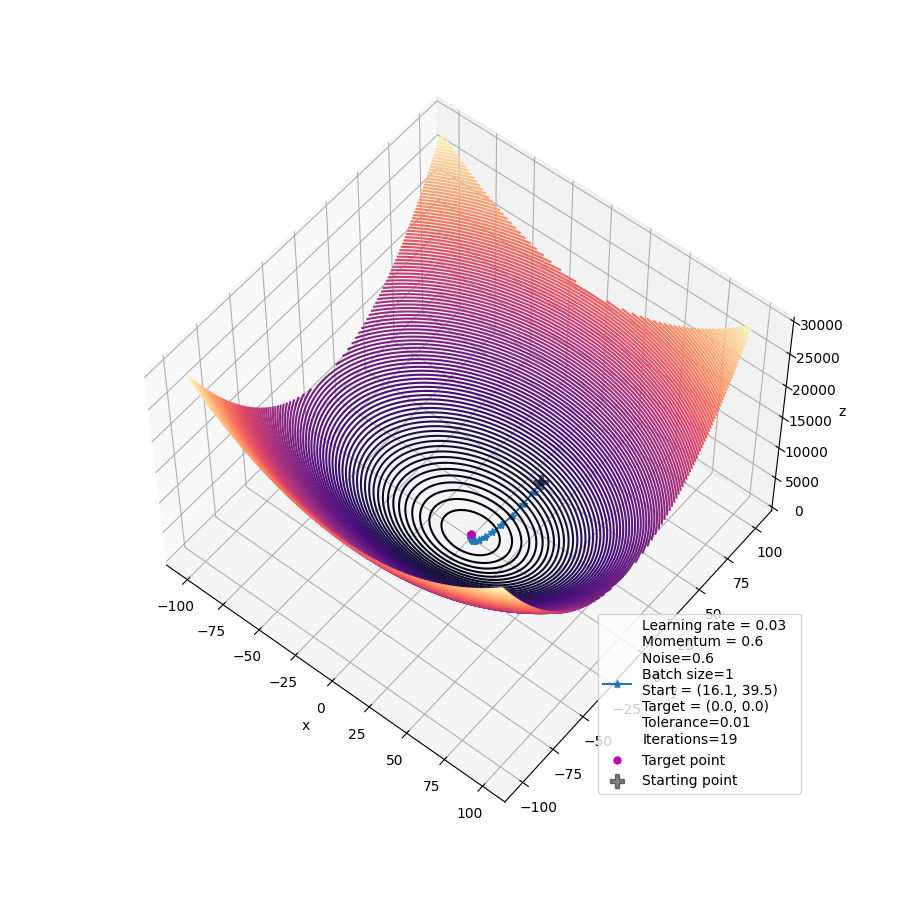

Widget Javascript not detected.  It may not be installed or enabled properly.


In [9]:
## 3D interactive plot

fig = plt.figure(figsize=(9,9))
ax = plt.axes(projection='3d')
def update_plot(lr,mom,startx,starty,targx,targy,noise,bsz,e,f,method):
    x = np.linspace(-100, 100, 400)
    y = np.linspace(-100, 100, 400)
    X, Y = np.meshgrid(x, y)
    Z = f((X, Y))
    ax.clear()
    vals=SGD(f,(startx,starty),lr=lr,lr_method=method,mom=mom,e=e,bsz=bsz,noise=noise)
    x,y=split(vals["Points"])
    z=[f(p) for p in vals["Points"]]
    units = 'Learning rate = {}  \nMomentum = {} \nNoise={} \nBatch size={} \nStart = {} \nTarget = {} \nTolerance={} \nIterations={}'
    ax.contour3D(X,Y,Z,100,cmap="magma")
    ax.plot(x,y,z,"-*",label=units.format(lr,mom,noise,bsz,(startx,starty),(targx,targy),e,len(x)-1))
    ax.plot(targx,targy,f3((targx,targy)),"om",label="Target point",ms=5)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.plot(startx,starty,f((startx,starty)),"Pk",ms=10,alpha=0.5,label="Starting point")
    ax.legend(loc=4)
    plt.show()


lr = widgets.FloatSlider(min=0, max=1, value=0.03,step=0.01, description='Learning rate:')
mom = widgets.FloatSlider(min=0, max=1, value=0.6,step=0.01, description='Momentum:')
noise = widgets.FloatSlider(min=0, max=10, value=0.6,step=0.01, description='Noise:')
bsz=widgets.IntSlider(min=1, max=10000, value=0.6, description='Batch size:')
startx = widgets.FloatSlider(min=-100, max=100, value=3, description='Start point X:')
starty = widgets.FloatSlider(min=-100, max=100, value=3, description='Start point Y:')
targx = widgets.FloatSlider(min=-100, max=100, value=0, description='Target point X:')
targy = widgets.FloatSlider(min=-100, max=100, value=0, description='Target point Y:')
e=widgets.FloatSlider(min=0, max=1, value=10e-3,step=10e-6, description='Tolerance:')
f=widgets.Dropdown(options=[f1,f2,f3], description="Select the function")
method=widgets.Dropdown(options=["Piecewise Linear","Exponential Decay","Polynomial Decay"], description="Select the scheduler")   

widgets.interactive(update_plot, lr=lr, mom=mom,bsz=bsz, startx=startx,starty=starty,targx=targx,targy=targy,e=e,noise=noise,f=f,method=method)